Standard imports for data analysis, plotting and fitting.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## Part 1 - Calibration

Read in the calibration data (skipping over the info at the head of the CSV file).

In [2]:
calib = pd.read_csv("calibration.csv", header=10)

Separate the two samples (this makes the indexing a lot simpler!) and drop the extraneous info.

In [3]:
S1 = calib.loc[calib.Sample == 'S1'].drop(columns=['Well','Sample'])
Blank = calib.loc[calib.Sample == 'Blank'].drop(columns=['Well','Sample','Dilution'])

Extract the wavelengths and dilutions tested.

In [4]:
x = S1.columns.values[1:].astype('int')
D = S1.Dilution.unique()

Calculate the mean for each triplicate measurement, taking the standard error $\frac{\sigma}{\sqrt{N}}$ as the uncertainty on the mean.

In [5]:
raw = S1.groupby('Dilution').mean().values
raw_err = S1.groupby('Dilution').std().values/np.sqrt(3)

Recall that for a combination of chemicals, the total absorbancy $A = \sum_i A_{i}$. The blank corrected absorbancy $A_{BC}$ is then given by $A_{BC} = A_{Sample}-A_{Blank}$. The error on the blank corrected mean is the sum of the errors on $A_S$ and $A_B$.

In [6]:
B = Blank.mean().values
B_err = Blank.std().values/np.sqrt(3)

In [7]:
corrected = raw-B
corrected_err = raw_err+B_err

Plot the raw and blank-corrected absorbancies for each dilution. Errors are indicated by a shaded area above and below each curve.

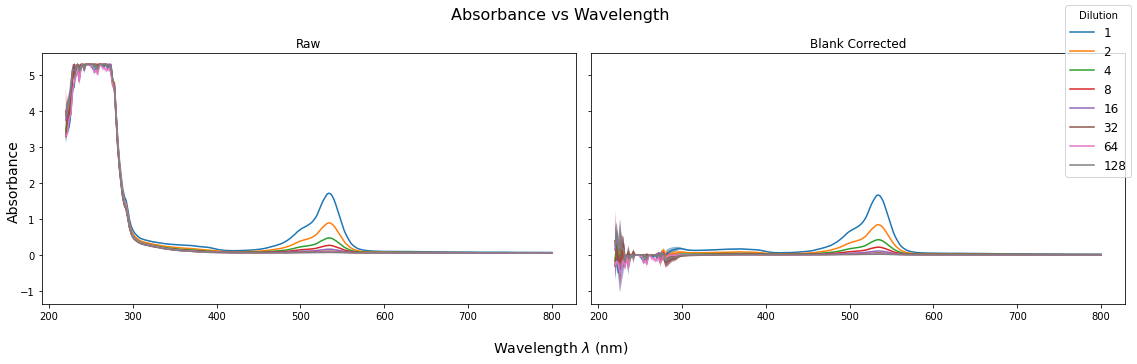

In [8]:
f, ax = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
f.suptitle("Absorbance vs Wavelength",fontsize=16)
f.supxlabel("Wavelength $\lambda$ (nm)", fontsize=14)
f.supylabel("Absorbance", fontsize=14)
for i in range (len(D)):
    ax[0].plot(x, raw[i], label=str(D[i]))
    ax[0].fill_between(x, (raw[i]-raw_err[i]), (raw[i]+raw_err[i]), alpha=0.5)
    ax[1].plot(x, corrected[i])
    ax[1].fill_between(x, (corrected[i]-corrected_err[i]), (corrected[i]+corrected_err[i]), alpha=0.5)
f.legend(title='Dilution', fontsize=12)
ax[0].set_title('Raw', fontsize=12)
ax[1].set_title('Blank Corrected', fontsize=12)
plt.tight_layout()
plt.show()

After correcting for the blank sample, the area of greatest interest (by inspection) is at $450<\lambda<600$nm, where the absorbance is maximised. The error on the calculated mean here is also negligible. At small $\lambda$, the statistical uncertainty dominates - however, since we're not too interested in this region, that's not a problem!

For a better look at the maximum absorbance, plot the (blank corrected) spectrum over a subrange of $\lambda$.

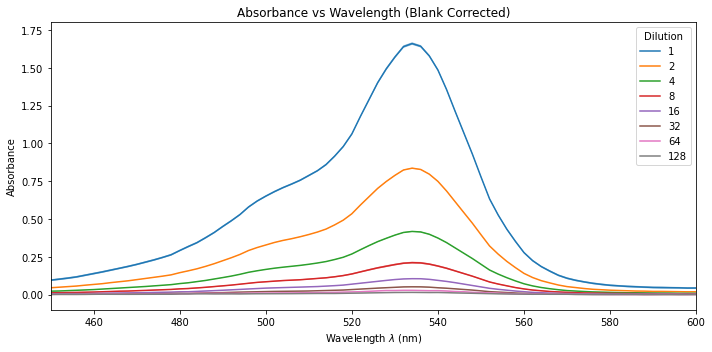

In [9]:
plt.figure(figsize=(10, 5))
plt.title("Absorbance vs Wavelength (Blank Corrected)",fontsize=12)
plt.xlabel("Wavelength $\lambda$ (nm)", fontsize=10)
plt.ylabel("Absorbance", fontsize=10)
for i in range (len(D)):
    plt.plot(x, corrected[i], label=str(D[i]))
    plt.fill_between(x, (corrected[i]-corrected_err[i]), (corrected[i]+corrected_err[i]), alpha=0.5)
plt.legend(title='Dilution')
plt.xlim(450,600)
plt.ylim(-0.1, 1.8)
plt.tight_layout()
plt.show()

Proceed with Part 2 and examine the unknown sample X1.

## Part 2 - Calculation

### Develop the model

Recall:
$A(\lambda,c) = E(\lambda)lc$. Then, for a given wavelength $\lambda_0$, define $A(c\,|\,\lambda_0) = E_0lc$.

Since $l$ is constant (1cm) across all the data, we can rewrite this as $A = \alpha c$. The constant of proportionality $\alpha$ can then be calculated from a linear fit on $A$ with respect to $c$ at $\lambda=\lambda_0$ (illustrated below).

In [10]:
l0 = 534

Many values of $\lambda_0$ in this well-defined region would be suitable; in this instance, we select $\lambda_0$ to correspond (approximately) with the peak of the absorbance.

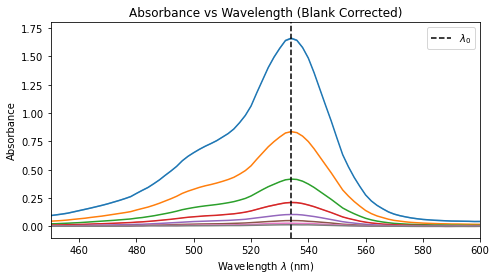

In [11]:
plt.figure(figsize=(7, 4))
plt.title("Absorbance vs Wavelength (Blank Corrected)")
plt.xlabel("Wavelength $\lambda$ (nm)")
plt.ylabel("Absorbance")
for i in range (len(D)):
    plt.plot(x, corrected[i])
    plt.fill_between(x, (corrected[i]-corrected_err[i]), (corrected[i]+corrected_err[i]), alpha=0.5)
plt.axvline(l0, ls='dashed', color='black', label='$\lambda_0$')
plt.legend()
plt.xlim(450,600)
plt.ylim(-0.1, 1.8)
plt.tight_layout()
plt.show()

Find the absorbance values $A(\lambda_0)$.

In [12]:
arg0 = np.where(x==l0)[0]
A_l0 = corrected[:,arg0].flatten()

To calculate concentration $c$ from the dilution $D$, use the relation: $c = 50D^{-1}$.

In [13]:
conc = 50 * (1/D)

Plot absorbance against concentration at $\lambda_0$.

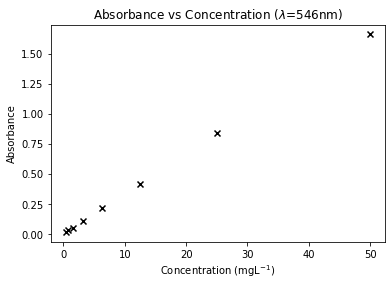

In [14]:
plt.scatter(conc, A_l0, marker='x', color='black')
plt.xlabel("Concentration (mgL$^{-1}$)")
plt.ylabel("Absorbance")
plt.title("Absorbance vs Concentration ($\lambda$=546nm)")
plt.show()

Perform a simple least-squares linear fit, forcing the y-intercept at (0,0). Since the statistical uncertainty from the calculated means is negligible in this region, the final uncertainty comes from the error on the fit (alpha_err).

In [15]:
def linear (x, a):
    return a*x
alpha, alphacov = curve_fit(linear, conc, A_l0)
alpha_err = np.sqrt(alphacov).flatten()

As above, the error on the fitted function is shown by a shaded area above and below the line (also as above, this error is negligible and not really visible!)

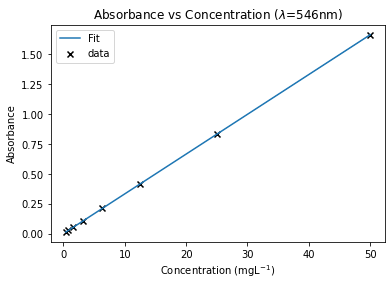

In [16]:
plt.scatter(conc, A_l0, marker='x', label='data', color='black')
plt.plot(conc, linear(conc, alpha), label='Fit')
plt.fill_between(conc, linear(conc, alpha-alpha_err), linear(conc, alpha+alpha_err))
plt.xlabel("Concentration (mgL$^{-1}$)")
plt.ylabel("Absorbance")
plt.title("Absorbance vs Concentration ($\lambda$=546nm)")
plt.legend()
plt.show()

### Apply to the sample

Read in the sample data, calculate the mean (and its error), and perform the blank correction.

In [17]:
test = pd.read_csv("sample.csv", header=10)
means = test.groupby('Sample').mean().values
errs = test.groupby('Sample').std().values/np.sqrt(3)

In [18]:
bc = means[1] - means[0]
bc_err = errs[1] + errs[0]

By error propagation, the uncertainty on the calculated value of $c$ is given by: $\delta_c = c\sqrt{(\frac{\delta_A}{A})^2+(\frac{\delta_\alpha}{\alpha})^2}$

In [19]:
A_x1 = bc[arg0]
A_err = bc_err[arg0]
c_x1 = (A_x1/alpha)[0]
c_err = c_x1 * np.sqrt((A_err/A_x1)**2+(alpha_err/alpha)**2)[0]

Illustrate the concentration and absorbance of X1 at $\lambda_0$ against the fit.

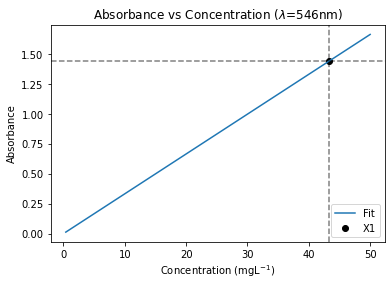

In [20]:
plt.plot(conc, linear(conc,alpha), label='Fit')
plt.scatter(c_x1, A_x1, marker='o', color='black', label='X1')
plt.axhline(A_x1, ls='dashed', alpha=0.5, color='black')
plt.axvline(c_x1, ls='dashed', alpha=0.5, color='black')
plt.xlabel("Concentration (mgL$^{-1}$)")
plt.ylabel("Absorbance")
plt.title("Absorbance vs Concentration ($\lambda$=546nm)")
plt.legend()
plt.show()

Final calculated concentration and error:

In [21]:
print(f"X1 Concentration: {c_x1:.3} (+/- {c_err:.1}) mg/L")

X1 Concentration: 43.4 (+/- 0.5) mg/L


Or, in terms of dilution:

In [22]:
dil = 50/c_x1
dil_err = dil * (c_err/c_x1)
print(f"X1 Dilution: {dil:.3} (+/- {dil_err:.1})")

X1 Dilution: 1.15 (+/- 0.01)


#### End of task!